### Feature Selection for Grit Classification

In this notebook, we perform three feature selection techniques to identify the most important survey questions for predicting the grit class:

1. Correlation-based filtering (using point-biserial / ANOVA-style correlation for classification)
2. L1-regularized Logistic Regression (classification version of Lasso)
3. Recursive Feature Elimination (RFE) with Logistic Regression

We use only the columns specified in our selected feature list (E1–E10, N1–N10, A1–A10, C1–C10, O1–O10, age groups, vocab score, and marital status).

The goal is to reduce noise, understand which questions matter most for classification, and prepare a strong feature subset for advanced modeling.


#### Importing required libraries

In [14]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import pointbiserialr

import matplotlib.pyplot as plt

#### Loading the Dataset

In [7]:
df = pd.read_csv('data/engineered_grit_data.csv')
df.head()

,surveyelapse,VCL1,VCL2,VCL3,VCL4,VCL5,VCL7,VCL8,VCL10,VCL11,...,operatingsystem_ChromeOS,operatingsystem_Linux,operatingsystem_Macintosh,operatingsystem_Unknown,operatingsystem_Windows,operatingsystem_Windows Phone,operatingsystem_iOS,age_group_18-30,age_group_30-45,age_group_45+
0,340,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,126,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,1,0
2,130,1,1,1,1,1,0,1,1,1,...,0,0,0,0,1,0,0,0,0,1
3,592,1,0,0,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
4,217,1,1,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0


#### Selecting required columns

In [8]:
columns = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'N1', 'N2',
       'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'A1', 'A2', 'A3', 'A4',
       'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6',
       'C7', 'C8', 'C9', 'C10', 'O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8',
       'O9', 'O10', 'age_group_18-30', 'age_group_30-45',
       'age_group_45+', 'vocab_score', 'married_Currently married',
       'married_Never married', 'married_Previously married']

target = "highgrit"

In [9]:
df = df[columns + [target]]
df.head()

,E1,E2,E3,E4,E5,E6,E7,E8,E9,E10,...,O9,O10,age_group_18-30,age_group_30-45,age_group_45+,vocab_score,married_Currently married,married_Never married,married_Previously married,highgrit
0,1,1,1,1,2,1,1,1,1,2,...,3,2,0,1,0,3,1,0,0,0
1,4,5,3,4,3,5,4,4,5,3,...,5,5,0,1,0,12,0,0,1,0
2,3,5,5,5,5,5,4,4,4,4,...,4,5,0,0,1,11,0,0,1,1
3,5,3,3,3,5,1,3,3,3,1,...,3,3,0,0,1,5,0,0,1,0
4,1,2,1,1,1,3,3,5,2,1,...,5,5,1,0,0,6,0,1,0,0


#### Correlation-Based Feature Selection

We compute the point-biserial correlation between each feature and Grit class and keep only those above a threshold.


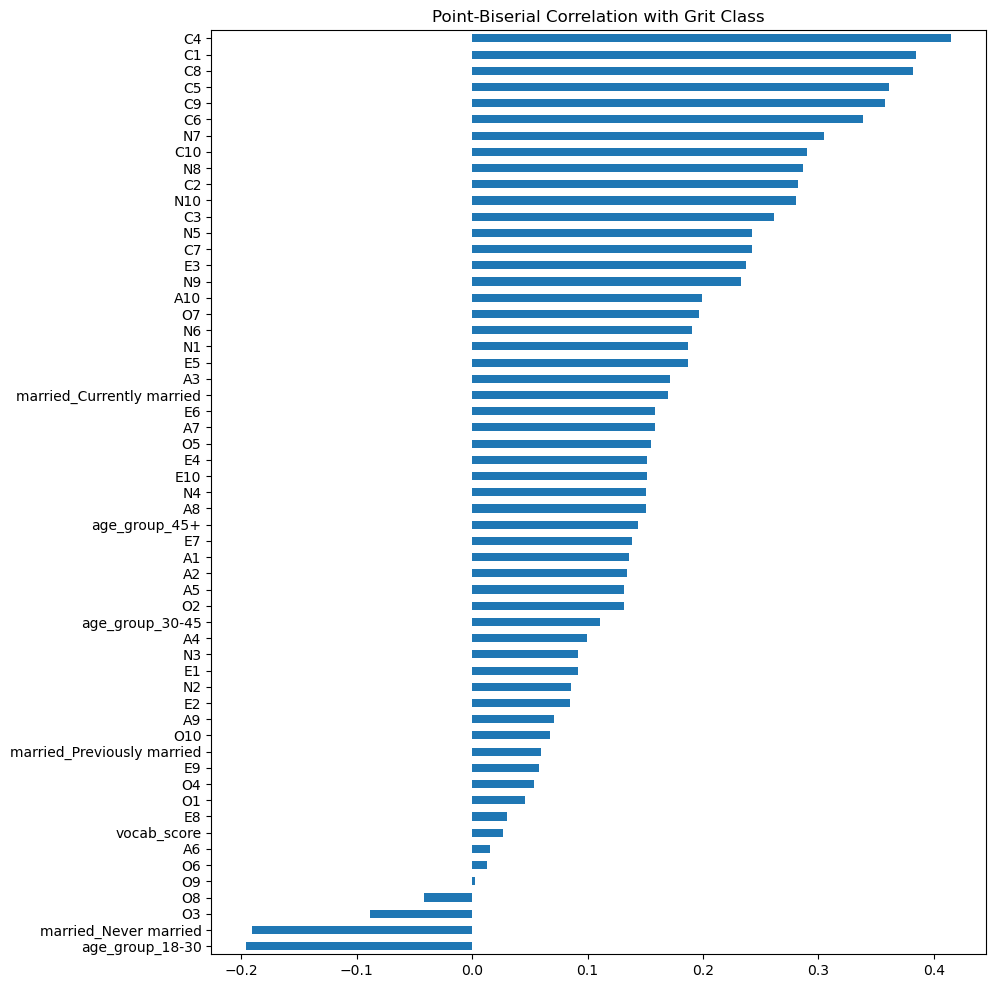

In [11]:
corr_values = {}

for col in columns:
    r, p = pointbiserialr(df[col], df[target])
    corr_values[col] = r

corr_series = pd.Series(corr_values).sort_values()

plt.figure(figsize=(10, 12))
corr_series.plot(kind="barh")
plt.title("Point-Biserial Correlation with Grit Class")
plt.show()


In [12]:
def select_by_correlation(corr_series, threshold=0.10):
    """
    Returns features with absolute correlation >= threshold.
    """
    return corr_series[abs(corr_series) >= threshold].index.tolist()

threshold = 0.10
selected_corr_features = select_by_correlation(corr_series, threshold)

len(selected_corr_features)

39

Updating the columns to selected_corr_features

In [13]:
columns = selected_corr_features

X = df[columns]
y = df[target]

#### L1 Logistic Regression Feature Selection

We use L1-regularized Logistic Regression to shrink coefficients and identify the most relevant features for predicting the grit class. The L1 penalty forces many coefficients to zero, allowing us to naturally perform feature selection while training a linear classifier.



In [24]:
logreg_l1 = LogisticRegression(
    penalty="l1",
    solver="liblinear",     
    C=0.05,
    max_iter=5000,
    random_state=42
)

pipeline_l1 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg_l1", logreg_l1)
])

pipeline_l1.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg_l1',
                 LogisticRegression(C=0.05, max_iter=5000, penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [25]:
l1_model = pipeline_l1.named_steps["logreg_l1"]
lasso_coefs = pd.Series(l1_model.coef_.ravel(), index=X.columns)

In [26]:
lasso_selected = lasso_coefs[lasso_coefs != 0].sort_values(ascending=False)

selected_lasso_features = list(lasso_selected.index)

len(selected_lasso_features)

29

Updating the columns to have only selected_lasso_features features

In [27]:
columns = selected_lasso_features

X = df[columns]
y = df[target]

#### Recursive Feature Elimination (RFE)

We use RFE with Logistic Regression to rank features and extract the top 15 most important predictors for the grit class. RFE works by recursively removing the least important features based on the model’s coefficients, allowing us to identify the strongest subset of survey questions for classification.

In [28]:
logreg_rfe = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=5000,
    random_state=42
)

rfe = RFE(estimator=logreg_rfe, n_features_to_select=15)
rfe.fit(X, y)

RFE(estimator=LogisticRegression(max_iter=5000, random_state=42),
    n_features_to_select=15)

In [29]:
rfe_ranking = pd.Series(rfe.ranking_, index=X.columns)
selected_rfe = rfe_ranking[rfe_ranking == 1].index.tolist()

In [30]:
print("Top 15 Features (RFE):")
selected_rfe

Top 15 Features (RFE):


['C8',
 'C1',
 'C5',
 'C4',
 'N7',
 'C9',
 'C3',
 'C10',
 'C2',
 'N10',
 'O7',
 'E6',
 'A10',
 'age_group_45+',
 'age_group_18-30']

In [31]:
columns = selected_rfe

In [32]:
print(columns)

['C8', 'C1', 'C5', 'C4', 'N7', 'C9', 'C3', 'C10', 'C2', 'N10', 'O7', 'E6', 'A10', 'age_group_45+', 'age_group_18-30']
